# Alternative Tracing Methods

![AWTT](images/alternative_ways_to_trace_0.png)

So far in this module, we've taken a look at the traceable decorator, and how we can use it to set up tracing.

In this lesson, we're going to look at alternative ways in which we can set up tracing, and when you should think about using these different approaches.

## LangChain and LangGraph

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables

![AWTT](images/alternative_ways_to_trace_1.png)

In [ ]:
# You can set them inline
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"  # If you don't set this, traces will go to the Default project

In [1]:
# Or you can use a .env file
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../.env", override=True)
os.environ["USER_AGENT"] = "496"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Don't worry too much about our graph implementation here, you can learn more about LangGraph through our LangGraph Academy course!

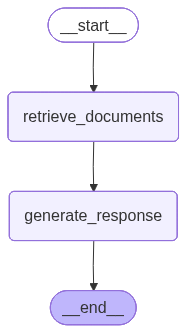

In [4]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatAnthropic(model_name="claude-sonnet-4-5-20250929", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

We're setting up a simple graph in LangGraph. If you want to learn more about LangGraph, I would highly recommend taking a look at our LangGraph Academy course.

You can also pass in metadata or other fields through an optional config

In [5]:
question = "How do I set up tracing if I'm using LangChain?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})

/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


{'question': "How do I set up tracing if I'm using LangChain?",
 'messages': [HumanMessage(content="How do I set up tracing if I'm using LangChain?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='To set up tracing with LangChain, you can set the `LANGSMITH_TRACING` environment variable to enable tracing for all invocations in your application. By default, traces will be logged to a project named "default", but you can customize this by setting the `LANGSMITH_PROJECT` environment variable to your desired project name. For more selective tracing in Python, you can use the `ls.tracing_context()` context manager or pass a `LangChainTracer` instance as a callback to specific invocations.', additional_kwargs={}, response_metadata={'id': 'msg_01BPchH2kFynnpz85jqeApn6', 'model': 'claude-sonnet-4-5-20250929', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation': {'ephemeral_1h_input_tokens': 0, 'ephemeral_5m_input_tokens': 0}, 'cache_creation_input_to

##### Let's take a look in LangSmith!

## Tracing Context Manager

In Python, you can use the trace context manager to log traces to LangSmith. This is useful in situations where:

You want to log traces for a specific block of code.
You want control over the inputs, outputs, and other attributes of the trace.
It is not feasible to use a decorator or wrapper.
Any or all of the above.
The context manager integrates seamlessly with the traceable decorator and wrap_openai wrapper, so you can use them together in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](images/alternative_ways_to_trace_2.png)

In [2]:
from langsmith import traceable, trace
from anthropic import Anthropic
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "anthropic"
MODEL_NAME = "claude-sonnet-4-5-20250929"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the latest question in the conversation.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
"""

anthropic_client = Anthropic()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_anthropic` to generate a model response after formatting inputs
"""
def generate_response(question: str, documents):
    # NOTE: Our documents came in as a list of objects, but we just want to log a string
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    with trace(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "formatted_docs": formatted_docs},
        metadata={"foo": "bar"},
    ) as ls_trace:
        messages = [
            {
                "role": "user",
                "content": f"{RAG_SYSTEM_PROMPT}\n\nContext: {formatted_docs}\n\nQuestion: {question}"
            }
        ]
        response = call_anthropic(messages)
        ls_trace.end(outputs={"output": response})

    return response

"""
call_anthropic
- Returns the chat completion output from Anthropic
"""
@traceable
def call_anthropic(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    response = anthropic_client.messages.create(
        model=model,
        max_tokens=1024,
        messages=messages,
        temperature=temperature,
    )
    return response

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.content[0].text

In [3]:
question = "How do I trace with tracing context?"
ai_answer = langsmith_rag(question)
print(ai_answer)

/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


To trace with tracing context in Python, you can use the `ls.tracing_context()` context manager from the langsmith library. Simply wrap your chain invocation with `with ls.tracing_context(enabled=True):` to enable tracing for specific code blocks. You can also set `enabled=False` to explicitly disable tracing for certain invocations, even if global tracing is enabled.


## wrap_openai

The wrap_openai/wrapOpenAI methods in Python/TypeScript allow you to wrap your OpenAI client in order to automatically log traces -- no decorator or function wrapping required! The wrapper works seamlessly with the @traceable decorator or traceable function and you can use both in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](images/alternative_ways_to_trace_3.png)

In [4]:
from langsmith.wrappers import wrap_anthropic
from anthropic import Anthropic
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "anthropic"
MODEL_NAME = "claude-sonnet-4-5-20250929"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the latest question in the conversation.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
"""

# Wrap the Anthropic Client
anthropic_client = wrap_anthropic(Anthropic())

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "user",
            "content": f"{RAG_SYSTEM_PROMPT}\n\nContext: {formatted_docs}\n\nQuestion: {question}"
        }
    ]
    # We don't need to use @traceable on call_anthropic anymore,
    # wrap_anthropic takes care of this for us
    return call_anthropic(messages)

def call_anthropic(messages: List[dict]) -> str:
    return anthropic_client.messages.create(
        model=MODEL_NAME,
        max_tokens=1024,
        messages=messages,
    )

@traceable(run_type="chain")
def langsmith_rag_with_wrap_anthropic(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.content[0].text

In [5]:
question = "How do I trace with wrap_anthropic?"
ai_answer = langsmith_rag_with_wrap_anthropic(question)
print(ai_answer)

/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


I don't know how to trace with wrap_anthropic based on the provided context. The context only discusses tracing with `wrap_openai` for OpenAI integration, not Anthropic. You would need to refer to LangSmith's documentation specific to Anthropic integrations for that information.


The wrapped OpenAI client accepts all the same langsmith_extra parameters as @traceable decorated functions

In [6]:
messages = [
    {
        "role": "user",
        "content": "What color is the sky?"
    }
]

anthropic_client.messages.create(
    model=MODEL_NAME,
    max_tokens=1024,
    messages=messages,
    langsmith_extra={"metadata": {"foo": "bar"}},
)

Message(id='msg_01Cr5QoevesB1D16uGtBb3Fk', content=[TextBlock(citations=None, text="The sky is typically blue during the day.\n\nThis happens because molecules in Earth's atmosphere scatter sunlight, and blue light is scattered more than other colors due to its shorter wavelength (a phenomenon called Rayleigh scattering).\n\nThe sky can appear different colors at other times:\n- **Red, orange, or pink** at sunrise and sunset\n- **Gray or white** on cloudy days\n- **Dark blue to black** at night\n- **Yellow or orange** in areas with pollution or dust", type='text')], model='claude-sonnet-4-5-20250929', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(cache_creation=CacheCreation(ephemeral_1h_input_tokens=0, ephemeral_5m_input_tokens=0), cache_creation_input_tokens=0, cache_read_input_tokens=0, input_tokens=13, output_tokens=111, server_tool_use=None, service_tier='standard'))

## [Advanced] RunTree

Another, more explicit way to log traces to LangSmith is via the RunTree API. This API allows you more control over your tracing - you can manually create runs and children runs to assemble your trace. You still need to set your `LANGSMITH_API_KEY`, but `LANGSMITH_TRACING` is not necessary for this method.

![AWTT](images/alternative_ways_to_trace_4.png)

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = ""
os.environ["LANGSMITH_API_KEY"] = ""
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"

In [1]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../.env", override=True)
os.environ["USER_AGENT"] = "496"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Let's go ahead and set `LANGSMITH_TRACING` to false, as we are using RunTree to manually create runs in this case.

In [2]:
import os
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # This should return false

False

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [3]:
from langsmith import RunTree
from anthropic import Anthropic
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

anthropic_client = Anthropic()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks.
    Use the following pieces of retrieved context to answer the latest question in the conversation.
    If you don't know the answer, just say that you don't know.
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "user",
            "content": f"{rag_system_prompt}\n\nContext: {formatted_docs}\n\nQuestion: {question}"
        }
    ]
    anthropic_response = call_anthropic(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"anthropic_response": anthropic_response})
    child_run.post()
    return anthropic_response

def call_anthropic(
    parent_run: RunTree, messages: List[dict], model: str = "claude-sonnet-4-5-20250929", temperature: float = 0.0
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name="Anthropic Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    anthropic_response = anthropic_client.messages.create(
        model=model,
        max_tokens=1024,
        messages=messages,
        temperature=temperature,
    )
    # Post the output of our child run
    child_run.end(outputs={"anthropic_response": anthropic_response})
    child_run.post()
    return anthropic_response

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.content[0].text

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output

In [4]:
question = "How can I trace with RunTree?"
ai_answer = langsmith_rag(question)
print(ai_answer)

/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ojas/PycharmProjects/ojaswk_/.venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Based on the context provided, you can trace with RunTree by converting LangChain's RunnableConfig to an equivalent RunTree object using `RunTree.fromRunnableConfig`. This allows you to integrate tracing when working with LangChain runnables. Alternatively, you can pass the RunnableConfig as the first argument of a traceable-wrapped function to maintain the trace context.
